In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [4]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

In [5]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [6]:
warnings.filterwarnings('ignore')

In [7]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [8]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.2, 0.2, size=nsamples)
    x_data = np.random.uniform(-0.98, 0.98, size=(nsamples, dim_x, dim_y)) - means[...,None,None]
    np.clip(x_data, -0.95, 0.95, out=x_data)
    return x_data


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.15, 0.15, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.3, 0.6, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [9]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return (((y1 - y2)*scale) ** 2).sum() / y1.data.nelement() 

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Data Generators

In [10]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, device=device)
    return x_data, y_data

In [41]:
%%time
x_data, y_data = data_generator(nsamples=16, 
                                dim_x=96, 
                                init_steps=1, 
                                delta_sim_steps = 2000,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

CPU times: user 309 ms, sys: 4.68 ms, total: 313 ms
Wall time: 318 ms


# Set Device

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [43]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).to(device)
summary(model, input_size=(1, 96, 96))

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
#                        in_channels=1, 
#                        out_channels=1, 
#                        init_features=32, 
#                        pretrained=False).double().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             288
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              ReLU-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 32, 96, 96]           9,216
       BatchNorm2d-5           [-1, 32, 96, 96]              64
              ReLU-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          18,432
       BatchNorm2d-9           [-1, 64, 48, 48]             128
             ReLU-10           [-1, 64, 48, 48]               0
           Conv2d-11           [-1, 64, 48, 48]          36,864
      BatchNorm2d-12           [-1, 64, 48, 48]             128
             ReLU-13           [-1, 64, 48, 48]               0
        MaxPool2d-14           [-1, 64,

(tensor(7762465), tensor(7762465))

In [44]:
# transformer_x = lambda x: x[None]
# transformer_y = lambda x: x[None]
from pymks.bases import LegendreBasis

n_states = 3
domain = (-1.01, 1.01)
basis = LegendreBasis(n_states, domain)
transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
transformer_y = lambda x: x[None]



dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 3, 96, 96]) torch.Size([1, 1, 96, 96])


In [45]:
model = UNet(in_channels=n_states, 
             out_channels=1, 
             init_features=32).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.3139, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [12]:
## Process Parameters
dim_x=64
init_steps=1
delta_sim_steps = 2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296


trn_size = 1
n_samples_trn = 1024*trn_size
n_samples_val = 256
n_samples_prd = 256

init_features=32

args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [13]:
%%time
# x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
#                               dim_x=dim_x, 
#                                 init_steps=init_steps, 
#                                 delta_sim_steps = delta_sim_steps,
#                                 dx = dx, 
#                                 dt = dt,
#                                 gamma=gamma, 
#                                 seed =seed_trn,
#                                 device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 4.56 s, sys: 1.69 s, total: 6.25 s
Wall time: 5.09 s


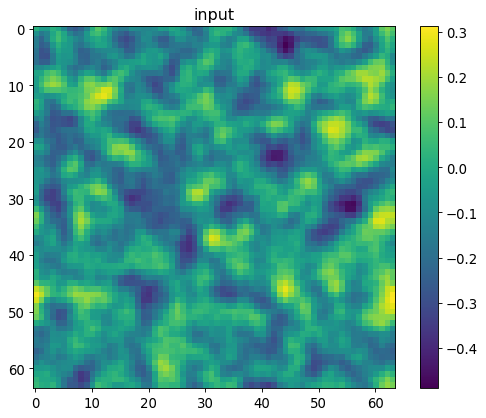

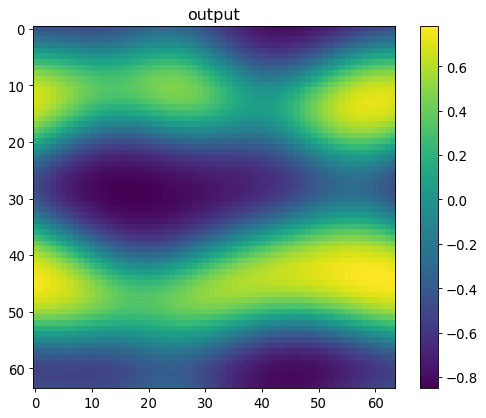

In [14]:
draw_im(x_val[0], "input")
draw_im(y_val[0], "output")

In [65]:
%time
# trn_seed = 9237919
# # trn_seed = 1381693
# # trn_seed = 38496502

# x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
#                               dim_x=dim_x, 
#                                 init_steps=init_steps, 
#                                 delta_sim_steps = delta_sim_steps,
#                                 dx = dx, 
#                                 dt = dt,
#                                 gamma=gamma, 
#                                 seed =seed_trn,
#                                 device = device)

In [15]:
# from pymks.bases import LegendreBasis

n_states = 1
# domain = (-1.01, 1.01)
# basis = LegendreBasis(n_states, domain)
# transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

# trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 8

# trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


# total_step = len(trn_loader)
# print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of validation steps: 32
No. of prediction steps: 32


In [16]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [17]:
run_id = dt_string + "_run_leg_{}_data_{}_small".format(n_states, trn_size)
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)


tag = folder+"unet_"
print(tag)

15-04-2020-02-27_run_leg_1_data_1_small
out/unet/ch_unet_id_15-04-2020-02-27_run_leg_1_data_1_small/
out/unet/ch_unet_id_15-04-2020-02-27_run_leg_1_data_1_small/unet_


In [18]:
if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)

In [19]:
from chnet.unet import UNet
model = UNet(in_channels=n_states, 
             out_channels=1, 
             init_features=init_features).double().to(device)

In [21]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [20]:
num_epochs = 50
criterion = mse_loss(scale=100)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
step_size = 4*len(train_loader)
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
trn_losses = []
val_losses = []
seed_list = []

In [22]:
num_epochs = 150
learning_rate = 1e-5

In [25]:
x_trn.shape

(1024, 64, 64)

In [26]:
# Loss and optimizer
for epoch in range(num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))
    
    if epoch % 5 == 0:
        s = np.random.randint(0, 100000, 1)[0]
        seed_list.append(s)
        x_trn, y_trn = data_generator(nsamples=1024*10, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =s,
                                device = device)
        
        trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
        trn_loader = DataLoader(trn_dataset, batch_size=8, shuffle=True, num_workers=2)
        total_step = len(trn_loader)
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_t = item_trn['y'].to(device)

        # Forward pass
        y_p = model(x)
        loss = criterion(y_t, y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 512 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 
torch.save(trn_losses, tag+"trn_loss.pt")
torch.save(val_losses, tag+"val_loss.pt")

Epoch [1/150], Step [1/1280], Training Loss: 17.26919346823, Validation Loss: 20.39269032190
Epoch [1/150], Step [513/1280], Training Loss: 18.27304083627, Validation Loss: 18.74395482265
Epoch [1/150], Step [1025/1280], Training Loss: 15.55900127063, Validation Loss: 15.86903141295



Epoch [2/150], Step [1/1280], Training Loss: 15.40535893037, Validation Loss: 12.81470135579
Epoch [2/150], Step [513/1280], Training Loss: 13.65699350475, Validation Loss: 13.04971340999
Epoch [2/150], Step [1025/1280], Training Loss: 13.20577658687, Validation Loss: 12.02354041642



Epoch [3/150], Step [1/1280], Training Loss: 12.62102546300, Validation Loss: 11.01910272801
Epoch [3/150], Step [513/1280], Training Loss: 12.34679926800, Validation Loss: 10.91728609365
Epoch [3/150], Step [1025/1280], Training Loss: 11.92205305972, Validation Loss: 10.39941813174



Epoch [4/150], Step [1/1280], Training Loss: 11.10417988072, Validation Loss: 9.23457083245
Epoch [4/150], Step [513/1280], Training Loss: 11.03637720393, Validation Loss: 10.06897718989
Epoch [4/150], Step [1025/1280], Training Loss: 10.71785601455, Validation Loss: 9.79892079056



Epoch [5/150], Step [1/1280], Training Loss: 10.68518318545, Validation Loss: 7.87476675817
Epoch [5/150], Step [513/1280], Training Loss: 10.25330781834, Validation Loss: 8.56228887262
Epoch [5/150], Step [1025/1280], Training Loss: 10.28551445800, Validation Loss: 7.97832790465



Epoch [6/150], Step [1/1280], Training Loss: 10.08739395863, Validation Loss: 8.33257917083
Epoch [6/150], Step [513/1280], Training Loss: 10.45138308542, Validation Loss: 9.57506945546
Epoch [6/150], Step [1025/1280], Training Loss: 9.74300089359, Validation Loss: 8.89228212557



Epoch [7/150], Step [1/1280], Training Loss: 10.28528288270, Validation Loss: 8.18007900013
Epoch [7/150], Step [513/1280], Training Loss: 9.51601658448, Validation Loss: 8.15509416217
Epoch [7/150], Step [1025/1280], Training Loss: 9.41572393522, Validation Loss: 7.77686677896



Epoch [8/150], Step [1/1280], Training Loss: 9.35929523381, Validation Loss: 7.18695659514
Epoch [8/150], Step [513/1280], Training Loss: 8.52068583498, Validation Loss: 7.98282889757
Epoch [8/150], Step [1025/1280], Training Loss: 9.92462403857, Validation Loss: 8.16420512557



Epoch [9/150], Step [1/1280], Training Loss: 8.47976631443, Validation Loss: 6.87792919316
Epoch [9/150], Step [513/1280], Training Loss: 8.13840583147, Validation Loss: 6.75556093444
Epoch [9/150], Step [1025/1280], Training Loss: 9.09622661426, Validation Loss: 7.48452122465



Epoch [10/150], Step [1/1280], Training Loss: 7.99971115626, Validation Loss: 6.89123171452
Epoch [10/150], Step [513/1280], Training Loss: 8.25420126356, Validation Loss: 6.17073683185
Epoch [10/150], Step [1025/1280], Training Loss: 8.05435057562, Validation Loss: 7.32103058913



Epoch [11/150], Step [1/1280], Training Loss: 7.73989108880, Validation Loss: 6.35442736213
Epoch [11/150], Step [513/1280], Training Loss: 8.64348424421, Validation Loss: 7.64799249911
Epoch [11/150], Step [1025/1280], Training Loss: 8.15858529225, Validation Loss: 6.55576459298



Epoch [12/150], Step [1/1280], Training Loss: 8.71588556880, Validation Loss: 7.67037844082
Epoch [12/150], Step [513/1280], Training Loss: 8.45625946119, Validation Loss: 6.72494443438
Epoch [12/150], Step [1025/1280], Training Loss: 7.72609366161, Validation Loss: 6.23067424872



Epoch [13/150], Step [1/1280], Training Loss: 7.40661749991, Validation Loss: 6.23684077473
Epoch [13/150], Step [513/1280], Training Loss: 7.72010595610, Validation Loss: 6.08279659357
Epoch [13/150], Step [1025/1280], Training Loss: 8.71412043321, Validation Loss: 6.65777556986



Epoch [14/150], Step [1/1280], Training Loss: 8.08477811077, Validation Loss: 6.47901995444
Epoch [14/150], Step [513/1280], Training Loss: 7.74563593357, Validation Loss: 5.84149901895
Epoch [14/150], Step [1025/1280], Training Loss: 6.99488895120, Validation Loss: 5.72564985006



Epoch [15/150], Step [1/1280], Training Loss: 7.76006439608, Validation Loss: 5.23038123141
Epoch [15/150], Step [513/1280], Training Loss: 7.58156709291, Validation Loss: 5.64449038981
Epoch [15/150], Step [1025/1280], Training Loss: 7.09836773412, Validation Loss: 5.46826063611



Epoch [16/150], Step [1/1280], Training Loss: 7.57327733105, Validation Loss: 6.18577554373
Epoch [16/150], Step [513/1280], Training Loss: 7.24038074249, Validation Loss: 5.65277016863
Epoch [16/150], Step [1025/1280], Training Loss: 8.76640191381, Validation Loss: 6.55608963725



Epoch [17/150], Step [1/1280], Training Loss: 7.96550109741, Validation Loss: 6.11338383927
Epoch [17/150], Step [513/1280], Training Loss: 7.65864345062, Validation Loss: 5.15751081294
Epoch [17/150], Step [1025/1280], Training Loss: 7.42588440130, Validation Loss: 5.57784687311



Epoch [18/150], Step [1/1280], Training Loss: 7.20625839996, Validation Loss: 5.97002152883
Epoch [18/150], Step [513/1280], Training Loss: 7.01851400604, Validation Loss: 5.68372323772
Epoch [18/150], Step [1025/1280], Training Loss: 7.37389769484, Validation Loss: 5.46856984566



Epoch [19/150], Step [1/1280], Training Loss: 6.97217965102, Validation Loss: 5.35131734334
Epoch [19/150], Step [513/1280], Training Loss: 6.68743735023, Validation Loss: 5.21790396214
Epoch [19/150], Step [1025/1280], Training Loss: 6.85833696886, Validation Loss: 5.30292790028



Epoch [20/150], Step [1/1280], Training Loss: 6.56000879643, Validation Loss: 5.49854048671
Epoch [20/150], Step [513/1280], Training Loss: 6.63648371160, Validation Loss: 5.75870550648
Epoch [20/150], Step [1025/1280], Training Loss: 7.09195942130, Validation Loss: 5.91340886257



Epoch [21/150], Step [1/1280], Training Loss: 6.38178666228, Validation Loss: 6.61892313039
Epoch [21/150], Step [513/1280], Training Loss: 8.06682797407, Validation Loss: 6.14584506606
Epoch [21/150], Step [1025/1280], Training Loss: 7.27482258403, Validation Loss: 6.28781848317



Epoch [22/150], Step [1/1280], Training Loss: 7.37456662342, Validation Loss: 5.22034264087
Epoch [22/150], Step [513/1280], Training Loss: 7.60509685097, Validation Loss: 5.31669791828
Epoch [22/150], Step [1025/1280], Training Loss: 7.51723362789, Validation Loss: 5.47416681582



Epoch [23/150], Step [1/1280], Training Loss: 6.71923439381, Validation Loss: 5.23953357224
Epoch [23/150], Step [513/1280], Training Loss: 6.79134222572, Validation Loss: 5.64352299831
Epoch [23/150], Step [1025/1280], Training Loss: 7.43118693881, Validation Loss: 5.80279782837



Epoch [24/150], Step [1/1280], Training Loss: 6.59601859877, Validation Loss: 4.57891813554
Epoch [24/150], Step [513/1280], Training Loss: 6.49438719015, Validation Loss: 4.97058498839
Epoch [24/150], Step [1025/1280], Training Loss: 6.74382744232, Validation Loss: 4.68412926673



Epoch [25/150], Step [1/1280], Training Loss: 6.46127033564, Validation Loss: 5.01567917949
Epoch [25/150], Step [513/1280], Training Loss: 5.65826545055, Validation Loss: 4.65376256104
Epoch [25/150], Step [1025/1280], Training Loss: 6.31003739171, Validation Loss: 5.20267861972



Epoch [26/150], Step [1/1280], Training Loss: 6.91034651979, Validation Loss: 5.71227670679
Epoch [26/150], Step [513/1280], Training Loss: 7.74592888500, Validation Loss: 6.36073368411
Epoch [26/150], Step [1025/1280], Training Loss: 7.63304534510, Validation Loss: 5.46562241823



Epoch [27/150], Step [1/1280], Training Loss: 7.57541601033, Validation Loss: 5.87525937214
Epoch [27/150], Step [513/1280], Training Loss: 7.52504634880, Validation Loss: 5.69186124605
Epoch [27/150], Step [1025/1280], Training Loss: 7.60397876154, Validation Loss: 4.63819211300



Epoch [28/150], Step [1/1280], Training Loss: 6.94159721839, Validation Loss: 6.57249024592
Epoch [28/150], Step [513/1280], Training Loss: 6.40413903757, Validation Loss: 4.90711314159
Epoch [28/150], Step [1025/1280], Training Loss: 6.21974965626, Validation Loss: 4.87110510900



Epoch [29/150], Step [1/1280], Training Loss: 7.07336106199, Validation Loss: 4.53776290360
Epoch [29/150], Step [513/1280], Training Loss: 6.47664606458, Validation Loss: 4.79488644078
Epoch [29/150], Step [1025/1280], Training Loss: 6.92744420932, Validation Loss: 5.43238959497



Epoch [30/150], Step [1/1280], Training Loss: 5.85775579210, Validation Loss: 4.02622410929
Epoch [30/150], Step [513/1280], Training Loss: 6.55761146774, Validation Loss: 4.61587086727
Epoch [30/150], Step [1025/1280], Training Loss: 6.29335464122, Validation Loss: 4.44973583287



Epoch [31/150], Step [1/1280], Training Loss: 5.69843915584, Validation Loss: 4.63736033455
Epoch [31/150], Step [513/1280], Training Loss: 6.68170204595, Validation Loss: 4.72856030298
Epoch [31/150], Step [1025/1280], Training Loss: 6.69726451404, Validation Loss: 4.65983877106



Epoch [32/150], Step [1/1280], Training Loss: 6.01779539748, Validation Loss: 4.75761525956
Epoch [32/150], Step [513/1280], Training Loss: 5.76304257565, Validation Loss: 4.62209062204
Epoch [32/150], Step [1025/1280], Training Loss: 5.71789121964, Validation Loss: 4.69443392213



Epoch [33/150], Step [1/1280], Training Loss: 6.75139839319, Validation Loss: 5.34562390047
Epoch [33/150], Step [513/1280], Training Loss: 6.99529515371, Validation Loss: 4.57694804765
Epoch [33/150], Step [1025/1280], Training Loss: 5.90946048590, Validation Loss: 4.70321334040



Epoch [34/150], Step [1/1280], Training Loss: 5.88589796004, Validation Loss: 3.93245642080
Epoch [34/150], Step [513/1280], Training Loss: 7.48542082588, Validation Loss: 4.96195484451
Epoch [34/150], Step [1025/1280], Training Loss: 6.07850024456, Validation Loss: 4.53204528909



Epoch [35/150], Step [1/1280], Training Loss: 6.00872896096, Validation Loss: 4.99992473671
Epoch [35/150], Step [513/1280], Training Loss: 5.69399357860, Validation Loss: 4.33265548869
Epoch [35/150], Step [1025/1280], Training Loss: 5.40210395688, Validation Loss: 4.36214700125



Epoch [36/150], Step [1/1280], Training Loss: 5.73706852758, Validation Loss: 4.42971386692
Epoch [36/150], Step [513/1280], Training Loss: 6.30341283451, Validation Loss: 5.09083278720
Epoch [36/150], Step [1025/1280], Training Loss: 6.23676558832, Validation Loss: 5.71583598212



Epoch [37/150], Step [1/1280], Training Loss: 6.63641960166, Validation Loss: 4.85278636408
Epoch [37/150], Step [513/1280], Training Loss: 5.70538110718, Validation Loss: 4.63619598548
Epoch [37/150], Step [1025/1280], Training Loss: 5.48234285688, Validation Loss: 4.50783764920



Epoch [38/150], Step [1/1280], Training Loss: 5.56774584608, Validation Loss: 4.76223691390
Epoch [38/150], Step [513/1280], Training Loss: 5.43149960411, Validation Loss: 3.98522956743
Epoch [38/150], Step [1025/1280], Training Loss: 6.18770389685, Validation Loss: 4.11063965739



Epoch [39/150], Step [1/1280], Training Loss: 6.99602309485, Validation Loss: 4.40742251783
Epoch [39/150], Step [513/1280], Training Loss: 5.61864137141, Validation Loss: 4.10926498900
Epoch [39/150], Step [1025/1280], Training Loss: 6.17026607237, Validation Loss: 4.43423649214



Epoch [40/150], Step [1/1280], Training Loss: 6.11071305818, Validation Loss: 5.09158113000
Epoch [40/150], Step [513/1280], Training Loss: 5.64702177350, Validation Loss: 3.94496229495
Epoch [40/150], Step [1025/1280], Training Loss: 6.08128901708, Validation Loss: 4.40037250588



Epoch [41/150], Step [1/1280], Training Loss: 6.40051375665, Validation Loss: 5.10777446544
Epoch [41/150], Step [513/1280], Training Loss: 6.34351460547, Validation Loss: 4.40719449728
Epoch [41/150], Step [1025/1280], Training Loss: 6.43150004746, Validation Loss: 4.43288380164



Epoch [42/150], Step [1/1280], Training Loss: 6.54077160161, Validation Loss: 4.41821867249
Epoch [42/150], Step [513/1280], Training Loss: 5.68490940972, Validation Loss: 4.43981103166
Epoch [42/150], Step [1025/1280], Training Loss: 5.79155767345, Validation Loss: 4.85799934095



Epoch [43/150], Step [1/1280], Training Loss: 6.24213942623, Validation Loss: 4.46909426320
Epoch [43/150], Step [513/1280], Training Loss: 6.41365404675, Validation Loss: 4.72014107592
Epoch [43/150], Step [1025/1280], Training Loss: 5.19058305185, Validation Loss: 3.82378658676



Epoch [44/150], Step [1/1280], Training Loss: 6.72569326767, Validation Loss: 4.16137073225
Epoch [44/150], Step [513/1280], Training Loss: 5.97301066194, Validation Loss: 3.68600679465
Epoch [44/150], Step [1025/1280], Training Loss: 5.92241352224, Validation Loss: 4.41798120770



Epoch [45/150], Step [1/1280], Training Loss: 6.27210366520, Validation Loss: 3.48968538606
Epoch [45/150], Step [513/1280], Training Loss: 5.28171049762, Validation Loss: 4.46729669735
Epoch [45/150], Step [1025/1280], Training Loss: 5.94148724726, Validation Loss: 4.77111699421



Epoch [46/150], Step [1/1280], Training Loss: 6.09355553842, Validation Loss: 5.29798763086
Epoch [46/150], Step [513/1280], Training Loss: 5.85246686068, Validation Loss: 4.37353117317
Epoch [46/150], Step [1025/1280], Training Loss: 5.27829176315, Validation Loss: 4.41841845237



Epoch [47/150], Step [1/1280], Training Loss: 6.24976744875, Validation Loss: 4.60473703422
Epoch [47/150], Step [513/1280], Training Loss: 5.84532982921, Validation Loss: 3.94125094468
Epoch [47/150], Step [1025/1280], Training Loss: 5.08631471110, Validation Loss: 4.93491994361



Epoch [48/150], Step [1/1280], Training Loss: 6.40427041441, Validation Loss: 3.96447206534
Epoch [48/150], Step [513/1280], Training Loss: 5.57675978535, Validation Loss: 4.38412382377
Epoch [48/150], Step [1025/1280], Training Loss: 5.13344899899, Validation Loss: 3.54404883637



Epoch [49/150], Step [1/1280], Training Loss: 5.53438863532, Validation Loss: 4.06653643891
Epoch [49/150], Step [513/1280], Training Loss: 4.94370574731, Validation Loss: 3.91942651047
Epoch [49/150], Step [1025/1280], Training Loss: 6.20429828800, Validation Loss: 4.05709279816



Epoch [50/150], Step [1/1280], Training Loss: 4.81537218892, Validation Loss: 4.05695847210
Epoch [50/150], Step [513/1280], Training Loss: 5.20271959104, Validation Loss: 3.70469710776
Epoch [50/150], Step [1025/1280], Training Loss: 5.25851561068, Validation Loss: 3.88328205006



Epoch [51/150], Step [1/1280], Training Loss: 5.41812244844, Validation Loss: 4.42478562968
Epoch [51/150], Step [513/1280], Training Loss: 5.65385731438, Validation Loss: 4.51743614591
Epoch [51/150], Step [1025/1280], Training Loss: 6.18557924205, Validation Loss: 5.67391617738



Epoch [52/150], Step [1/1280], Training Loss: 5.67254892802, Validation Loss: 3.93732335093
Epoch [52/150], Step [513/1280], Training Loss: 6.06822345187, Validation Loss: 4.29131060858
Epoch [52/150], Step [1025/1280], Training Loss: 5.25599423316, Validation Loss: 4.37236693324



Epoch [53/150], Step [1/1280], Training Loss: 6.12679264857, Validation Loss: 4.12478059205
Epoch [53/150], Step [513/1280], Training Loss: 5.49594394511, Validation Loss: 4.01054475890
Epoch [53/150], Step [1025/1280], Training Loss: 5.39751354313, Validation Loss: 3.91487890920



Epoch [54/150], Step [1/1280], Training Loss: 5.42691033592, Validation Loss: 4.38618834346
Epoch [54/150], Step [513/1280], Training Loss: 5.73721701770, Validation Loss: 4.44543023752
Epoch [54/150], Step [1025/1280], Training Loss: 5.68340695332, Validation Loss: 3.81911364842



Epoch [55/150], Step [1/1280], Training Loss: 5.72473901304, Validation Loss: 3.69578239805
Epoch [55/150], Step [513/1280], Training Loss: 5.11470715688, Validation Loss: 3.61625813208
Epoch [55/150], Step [1025/1280], Training Loss: 5.14413655869, Validation Loss: 3.68241793432



Epoch [56/150], Step [1/1280], Training Loss: 6.17990894014, Validation Loss: 4.30266518222
Epoch [56/150], Step [513/1280], Training Loss: 5.74261369487, Validation Loss: 3.93988564335
Epoch [56/150], Step [1025/1280], Training Loss: 5.54134953303, Validation Loss: 4.24057384228



Epoch [57/150], Step [1/1280], Training Loss: 5.67032820385, Validation Loss: 4.09147135256
Epoch [57/150], Step [513/1280], Training Loss: 4.95162357297, Validation Loss: 3.68659944859
Epoch [57/150], Step [1025/1280], Training Loss: 6.10243418409, Validation Loss: 4.86250129745



Epoch [58/150], Step [1/1280], Training Loss: 5.67556318523, Validation Loss: 4.29636041186
Epoch [58/150], Step [513/1280], Training Loss: 5.94461004032, Validation Loss: 4.33757301138
Epoch [58/150], Step [1025/1280], Training Loss: 4.86487204582, Validation Loss: 3.60897908295



Epoch [59/150], Step [1/1280], Training Loss: 6.24669822657, Validation Loss: 4.39975326575
Epoch [59/150], Step [513/1280], Training Loss: 5.41328456333, Validation Loss: 4.17502627107
Epoch [59/150], Step [1025/1280], Training Loss: 5.65976364341, Validation Loss: 3.69853050833



Epoch [60/150], Step [1/1280], Training Loss: 4.80031462838, Validation Loss: 3.76441935651
Epoch [60/150], Step [513/1280], Training Loss: 4.94223674673, Validation Loss: 4.07183578197
Epoch [60/150], Step [1025/1280], Training Loss: 5.11242169360, Validation Loss: 3.41860673748



Epoch [61/150], Step [1/1280], Training Loss: 5.07479906342, Validation Loss: 4.13729906163
Epoch [61/150], Step [513/1280], Training Loss: 5.43715280655, Validation Loss: 3.98414207341
Epoch [61/150], Step [1025/1280], Training Loss: 4.80086670077, Validation Loss: 4.23477063623



Epoch [62/150], Step [1/1280], Training Loss: 5.22597746007, Validation Loss: 3.77773158576
Epoch [62/150], Step [513/1280], Training Loss: 4.78076758387, Validation Loss: 3.78378780700
Epoch [62/150], Step [1025/1280], Training Loss: 4.88703420866, Validation Loss: 4.34575334173



Epoch [63/150], Step [1/1280], Training Loss: 5.11195226509, Validation Loss: 4.20063281077
Epoch [63/150], Step [513/1280], Training Loss: 4.82015405644, Validation Loss: 3.70663974498
Epoch [63/150], Step [1025/1280], Training Loss: 5.28927529102, Validation Loss: 4.43700466522



Epoch [64/150], Step [1/1280], Training Loss: 4.92695986454, Validation Loss: 3.92535795267
Epoch [64/150], Step [513/1280], Training Loss: 4.83179988925, Validation Loss: 3.55294293740
Epoch [64/150], Step [1025/1280], Training Loss: 4.65921564303, Validation Loss: 3.82233592870



Epoch [65/150], Step [1/1280], Training Loss: 4.99931205890, Validation Loss: 3.37108710111
Epoch [65/150], Step [513/1280], Training Loss: 5.05027314585, Validation Loss: 3.75824357060
Epoch [65/150], Step [1025/1280], Training Loss: 4.37210951722, Validation Loss: 3.85468119850



Epoch [66/150], Step [1/1280], Training Loss: 4.46223599951, Validation Loss: 3.69482507016
Epoch [66/150], Step [513/1280], Training Loss: 4.71435392663, Validation Loss: 4.60555930465
Epoch [66/150], Step [1025/1280], Training Loss: 4.93273659394, Validation Loss: 3.91625258388



Epoch [67/150], Step [1/1280], Training Loss: 4.62805892440, Validation Loss: 4.18575521789
Epoch [67/150], Step [513/1280], Training Loss: 4.63992157613, Validation Loss: 3.34074644256
Epoch [67/150], Step [1025/1280], Training Loss: 4.82456766204, Validation Loss: 4.15973794681



Epoch [68/150], Step [1/1280], Training Loss: 5.07035184146, Validation Loss: 3.91481163230
Epoch [68/150], Step [513/1280], Training Loss: 4.23632369266, Validation Loss: 3.33453924754
Epoch [68/150], Step [1025/1280], Training Loss: 4.64547629068, Validation Loss: 3.94529985134



Epoch [69/150], Step [1/1280], Training Loss: 4.28098004239, Validation Loss: 3.51196701178
Epoch [69/150], Step [513/1280], Training Loss: 4.46900972623, Validation Loss: 3.33465215330
Epoch [69/150], Step [1025/1280], Training Loss: 4.49546497875, Validation Loss: 3.96646776539



Epoch [70/150], Step [1/1280], Training Loss: 4.46473356608, Validation Loss: 3.46568404974
Epoch [70/150], Step [513/1280], Training Loss: 4.00731646298, Validation Loss: 3.48675221969
Epoch [70/150], Step [1025/1280], Training Loss: 4.53609697785, Validation Loss: 3.70428268268



Epoch [71/150], Step [1/1280], Training Loss: 4.17555719624, Validation Loss: 3.60883975922
Epoch [71/150], Step [513/1280], Training Loss: 4.59334114060, Validation Loss: 3.88234975334
Epoch [71/150], Step [1025/1280], Training Loss: 4.87034614492, Validation Loss: 3.94517431704



Epoch [72/150], Step [1/1280], Training Loss: 4.95807301066, Validation Loss: 3.99806790155
Epoch [72/150], Step [513/1280], Training Loss: 4.43911413624, Validation Loss: 3.81150056943
Epoch [72/150], Step [1025/1280], Training Loss: 4.34081754038, Validation Loss: 3.52125719719



Epoch [73/150], Step [1/1280], Training Loss: 4.30899977678, Validation Loss: 3.52764040119
Epoch [73/150], Step [513/1280], Training Loss: 4.42712467917, Validation Loss: 3.51195586480
Epoch [73/150], Step [1025/1280], Training Loss: 4.18416624252, Validation Loss: 3.31637547023



Epoch [74/150], Step [1/1280], Training Loss: 4.20333204820, Validation Loss: 3.38764814558
Epoch [74/150], Step [513/1280], Training Loss: 4.34729179686, Validation Loss: 3.49725919401
Epoch [74/150], Step [1025/1280], Training Loss: 4.42098661055, Validation Loss: 3.28886660089



Epoch [75/150], Step [1/1280], Training Loss: 4.16226393268, Validation Loss: 3.45499696668
Epoch [75/150], Step [513/1280], Training Loss: 4.38769380728, Validation Loss: 3.30598137199
Epoch [75/150], Step [1025/1280], Training Loss: 4.21418922285, Validation Loss: 3.59732640096



Epoch [76/150], Step [1/1280], Training Loss: 4.45184817238, Validation Loss: 3.59195131923
Epoch [76/150], Step [513/1280], Training Loss: 4.32769710593, Validation Loss: 3.51038932336
Epoch [76/150], Step [1025/1280], Training Loss: 4.36147587638, Validation Loss: 3.70883097416



Epoch [77/150], Step [1/1280], Training Loss: 4.32146001515, Validation Loss: 3.41393674112
Epoch [77/150], Step [513/1280], Training Loss: 4.27361857688, Validation Loss: 3.04082062618
Epoch [77/150], Step [1025/1280], Training Loss: 4.10302856548, Validation Loss: 3.42187860151



Epoch [78/150], Step [1/1280], Training Loss: 4.08003054096, Validation Loss: 2.94815300076
Epoch [78/150], Step [513/1280], Training Loss: 4.15138511548, Validation Loss: 3.96830154133
Epoch [78/150], Step [1025/1280], Training Loss: 4.08027271861, Validation Loss: 3.41687993988



Epoch [79/150], Step [1/1280], Training Loss: 4.20043458818, Validation Loss: 3.35029492930
Epoch [79/150], Step [513/1280], Training Loss: 4.02865489842, Validation Loss: 3.10497585037
Epoch [79/150], Step [1025/1280], Training Loss: 4.01491197939, Validation Loss: 3.06420787867



Epoch [80/150], Step [1/1280], Training Loss: 3.99069307265, Validation Loss: 3.47804289604
Epoch [80/150], Step [513/1280], Training Loss: 3.73428250711, Validation Loss: 3.32499991095
Epoch [80/150], Step [1025/1280], Training Loss: 3.75990094995, Validation Loss: 3.61450849053



Epoch [81/150], Step [1/1280], Training Loss: 3.91822763715, Validation Loss: 3.66015357578
Epoch [81/150], Step [513/1280], Training Loss: 4.07312441860, Validation Loss: 3.47638602490
Epoch [81/150], Step [1025/1280], Training Loss: 3.93521614029, Validation Loss: 3.18552476495



Epoch [82/150], Step [1/1280], Training Loss: 3.96763063071, Validation Loss: 3.60634098428
Epoch [82/150], Step [513/1280], Training Loss: 3.85561816897, Validation Loss: 2.52132732431
Epoch [82/150], Step [1025/1280], Training Loss: 3.83722530851, Validation Loss: 3.40483501547



Epoch [83/150], Step [1/1280], Training Loss: 4.13467769160, Validation Loss: 3.44936805025
Epoch [83/150], Step [513/1280], Training Loss: 3.92395553311, Validation Loss: 3.23583367123
Epoch [83/150], Step [1025/1280], Training Loss: 4.13237952506, Validation Loss: 3.38933699682



Epoch [84/150], Step [1/1280], Training Loss: 3.67620528208, Validation Loss: 3.32363275457
Epoch [84/150], Step [513/1280], Training Loss: 3.92649018017, Validation Loss: 3.32853778807
Epoch [84/150], Step [1025/1280], Training Loss: 3.77303640624, Validation Loss: 3.82418699351



Epoch [85/150], Step [1/1280], Training Loss: 3.83578127573, Validation Loss: 3.36070208831
Epoch [85/150], Step [513/1280], Training Loss: 3.60048774867, Validation Loss: 3.30482546539
Epoch [85/150], Step [1025/1280], Training Loss: 3.75983267609, Validation Loss: 3.17802931173



Epoch [86/150], Step [1/1280], Training Loss: 3.71716191805, Validation Loss: 3.68079662832
Epoch [86/150], Step [513/1280], Training Loss: 4.07589621858, Validation Loss: 3.61413340723
Epoch [86/150], Step [1025/1280], Training Loss: 4.17814268871, Validation Loss: 3.57447644967



Epoch [87/150], Step [1/1280], Training Loss: 3.89462568494, Validation Loss: 3.33331077172
Epoch [87/150], Step [513/1280], Training Loss: 3.89406883920, Validation Loss: 3.33915663875
Epoch [87/150], Step [1025/1280], Training Loss: 3.72642522086, Validation Loss: 3.58890302437



Epoch [88/150], Step [1/1280], Training Loss: 3.67824127422, Validation Loss: 3.45978906405
Epoch [88/150], Step [513/1280], Training Loss: 3.80521381061, Validation Loss: 4.60719821434
Epoch [88/150], Step [1025/1280], Training Loss: 4.07193108898, Validation Loss: 3.58383476387



Epoch [89/150], Step [1/1280], Training Loss: 3.72314777101, Validation Loss: 4.00932565484
Epoch [89/150], Step [513/1280], Training Loss: 4.19500199556, Validation Loss: 3.41206111771
Epoch [89/150], Step [1025/1280], Training Loss: 3.62330647636, Validation Loss: 3.37341223535



Epoch [90/150], Step [1/1280], Training Loss: 4.06693734657, Validation Loss: 2.81144584267
Epoch [90/150], Step [513/1280], Training Loss: 3.59853081135, Validation Loss: 3.29999152960
Epoch [90/150], Step [1025/1280], Training Loss: 3.72858249906, Validation Loss: 3.63282756088



Epoch [91/150], Step [1/1280], Training Loss: 3.70961917392, Validation Loss: 3.27544610248
Epoch [91/150], Step [513/1280], Training Loss: 3.81291353971, Validation Loss: 3.18725286453
Epoch [91/150], Step [1025/1280], Training Loss: 3.79901326970, Validation Loss: 3.25323510512



Epoch [92/150], Step [1/1280], Training Loss: 3.67411095861, Validation Loss: 3.13743465666
Epoch [92/150], Step [513/1280], Training Loss: 3.73232399733, Validation Loss: 3.57772520473
Epoch [92/150], Step [1025/1280], Training Loss: 3.62124960641, Validation Loss: 3.34596875065



Epoch [93/150], Step [1/1280], Training Loss: 3.60126985247, Validation Loss: 3.33761662943
Epoch [93/150], Step [513/1280], Training Loss: 3.93812908826, Validation Loss: 3.68979025318
Epoch [93/150], Step [1025/1280], Training Loss: 3.78051931210, Validation Loss: 3.24319453763



Epoch [94/150], Step [1/1280], Training Loss: 3.59616652361, Validation Loss: 3.26338581544
Epoch [94/150], Step [513/1280], Training Loss: 3.37803674428, Validation Loss: 3.52459065699
Epoch [94/150], Step [1025/1280], Training Loss: 3.65472543999, Validation Loss: 3.09293657504



Epoch [95/150], Step [1/1280], Training Loss: 3.52010649392, Validation Loss: 2.81061418544
Epoch [95/150], Step [513/1280], Training Loss: 3.32069600090, Validation Loss: 3.20485098841
Epoch [95/150], Step [1025/1280], Training Loss: 3.57673945344, Validation Loss: 3.40846031526



Epoch [96/150], Step [1/1280], Training Loss: 3.52587836998, Validation Loss: 3.60302684281
Epoch [96/150], Step [513/1280], Training Loss: 3.69544844817, Validation Loss: 3.33103643237
Epoch [96/150], Step [1025/1280], Training Loss: 3.74000499623, Validation Loss: 3.33491731067



Epoch [97/150], Step [1/1280], Training Loss: 3.79307900494, Validation Loss: 3.00950943013
Epoch [97/150], Step [513/1280], Training Loss: 3.53067576575, Validation Loss: 3.35626423046
Epoch [97/150], Step [1025/1280], Training Loss: 3.54225116275, Validation Loss: 3.68628239148



Epoch [98/150], Step [1/1280], Training Loss: 3.66132336920, Validation Loss: 2.78301561039
Epoch [98/150], Step [513/1280], Training Loss: 3.62669278088, Validation Loss: 3.51194570244
Epoch [98/150], Step [1025/1280], Training Loss: 3.38770877199, Validation Loss: 2.92461638878



Epoch [99/150], Step [1/1280], Training Loss: 3.49518856939, Validation Loss: 3.47307736466
Epoch [99/150], Step [513/1280], Training Loss: 3.19476128696, Validation Loss: 3.02217996419
Epoch [99/150], Step [1025/1280], Training Loss: 3.45134156950, Validation Loss: 2.67651213528



Epoch [100/150], Step [1/1280], Training Loss: 3.61325793679, Validation Loss: 2.52518183955
Epoch [100/150], Step [513/1280], Training Loss: 3.31580344556, Validation Loss: 2.95813341996
Epoch [100/150], Step [1025/1280], Training Loss: 3.29777210301, Validation Loss: 3.08227620171



Epoch [101/150], Step [1/1280], Training Loss: 3.54112026027, Validation Loss: 3.42157238702
Epoch [101/150], Step [513/1280], Training Loss: 3.66548869690, Validation Loss: 3.26655822931
Epoch [101/150], Step [1025/1280], Training Loss: 3.92764102080, Validation Loss: 3.69994776630



Epoch [102/150], Step [1/1280], Training Loss: 3.65663866739, Validation Loss: 3.13651627541
Epoch [102/150], Step [513/1280], Training Loss: 3.36224030349, Validation Loss: 3.02910863941
Epoch [102/150], Step [1025/1280], Training Loss: 3.44429274569, Validation Loss: 3.39824562023



Epoch [103/150], Step [1/1280], Training Loss: 3.46247750179, Validation Loss: 2.87573952159
Epoch [103/150], Step [513/1280], Training Loss: 3.50282076653, Validation Loss: 3.34186731401
Epoch [103/150], Step [1025/1280], Training Loss: 3.27849650666, Validation Loss: 3.15044208588



Epoch [104/150], Step [1/1280], Training Loss: 3.27087173966, Validation Loss: 2.98352339200
Epoch [104/150], Step [513/1280], Training Loss: 3.34878043896, Validation Loss: 2.51462232751
Epoch [104/150], Step [1025/1280], Training Loss: 3.37590081204, Validation Loss: 3.20814039275



Epoch [105/150], Step [1/1280], Training Loss: 3.26442197196, Validation Loss: 2.54469195030
Epoch [105/150], Step [513/1280], Training Loss: 3.31443035980, Validation Loss: 3.09455104243
Epoch [105/150], Step [1025/1280], Training Loss: 3.33016636467, Validation Loss: 2.87722075708



Epoch [106/150], Step [1/1280], Training Loss: 3.40977148499, Validation Loss: 2.86928627731
Epoch [106/150], Step [513/1280], Training Loss: 3.53788709204, Validation Loss: 3.45888451522
Epoch [106/150], Step [1025/1280], Training Loss: 3.19054170414, Validation Loss: 3.25614421448



Epoch [107/150], Step [1/1280], Training Loss: 3.44403236702, Validation Loss: 3.17416453775
Epoch [107/150], Step [513/1280], Training Loss: 3.52617368190, Validation Loss: 3.42391435927
Epoch [107/150], Step [1025/1280], Training Loss: 3.19999894249, Validation Loss: 3.14493194903



Epoch [108/150], Step [1/1280], Training Loss: 3.42572223852, Validation Loss: 2.91122808475
Epoch [108/150], Step [513/1280], Training Loss: 3.30291255876, Validation Loss: 3.11672739464
Epoch [108/150], Step [1025/1280], Training Loss: 3.31507200884, Validation Loss: 3.02831215777



Epoch [109/150], Step [1/1280], Training Loss: 3.66046352308, Validation Loss: 3.18912998219
Epoch [109/150], Step [513/1280], Training Loss: 3.30111047967, Validation Loss: 2.57823501364
Epoch [109/150], Step [1025/1280], Training Loss: 3.28895446590, Validation Loss: 3.13308150120



Epoch [110/150], Step [1/1280], Training Loss: 3.32842459292, Validation Loss: 2.82495452265
Epoch [110/150], Step [513/1280], Training Loss: 3.20947944729, Validation Loss: 3.22888488292
Epoch [110/150], Step [1025/1280], Training Loss: 2.91717168418, Validation Loss: 2.67845961090



Epoch [111/150], Step [1/1280], Training Loss: 3.48435841055, Validation Loss: 2.94424534331
Epoch [111/150], Step [513/1280], Training Loss: 3.32392687303, Validation Loss: 3.25724679239
Epoch [111/150], Step [1025/1280], Training Loss: 3.65665983666, Validation Loss: 2.66162863041



Epoch [112/150], Step [1/1280], Training Loss: 3.71988561959, Validation Loss: 3.37706943322
Epoch [112/150], Step [513/1280], Training Loss: 3.23166862017, Validation Loss: 2.93279816684
Epoch [112/150], Step [1025/1280], Training Loss: 3.39007271787, Validation Loss: 2.89656210023



Epoch [113/150], Step [1/1280], Training Loss: 3.24930503225, Validation Loss: 3.00518430646
Epoch [113/150], Step [513/1280], Training Loss: 3.11462223375, Validation Loss: 3.33655465734
Epoch [113/150], Step [1025/1280], Training Loss: 3.11022933630, Validation Loss: 2.97289076861



Epoch [114/150], Step [1/1280], Training Loss: 3.28114041770, Validation Loss: 3.05039052024
Epoch [114/150], Step [513/1280], Training Loss: 3.59448654557, Validation Loss: 3.78937123277
Epoch [114/150], Step [1025/1280], Training Loss: 3.28438166794, Validation Loss: 3.32446534414



Epoch [115/150], Step [1/1280], Training Loss: 3.17500467822, Validation Loss: 3.08766308481
Epoch [115/150], Step [513/1280], Training Loss: 3.31757690407, Validation Loss: 3.16790289336
Epoch [115/150], Step [1025/1280], Training Loss: 3.13002735058, Validation Loss: 2.82392176659



Epoch [116/150], Step [1/1280], Training Loss: 3.07694300994, Validation Loss: 3.21574622251
Epoch [116/150], Step [513/1280], Training Loss: 3.14927186575, Validation Loss: 2.98118825316
Epoch [116/150], Step [1025/1280], Training Loss: 3.40413914686, Validation Loss: 3.21869001092



Epoch [117/150], Step [1/1280], Training Loss: 3.34601021915, Validation Loss: 2.98665913585
Epoch [117/150], Step [513/1280], Training Loss: 3.36257843515, Validation Loss: 3.08513645459
Epoch [117/150], Step [1025/1280], Training Loss: 3.12160412917, Validation Loss: 2.69430458293



Epoch [118/150], Step [1/1280], Training Loss: 3.30408950621, Validation Loss: 2.64205883534
Epoch [118/150], Step [513/1280], Training Loss: 3.05166905016, Validation Loss: 2.57149733177
Epoch [118/150], Step [1025/1280], Training Loss: 3.24543085968, Validation Loss: 2.79088965835



Epoch [119/150], Step [1/1280], Training Loss: 3.10003238502, Validation Loss: 3.46960198737
Epoch [119/150], Step [513/1280], Training Loss: 3.06165758977, Validation Loss: 2.94366539222
Epoch [119/150], Step [1025/1280], Training Loss: 3.25016217485, Validation Loss: 2.67385154872



Epoch [120/150], Step [1/1280], Training Loss: 3.41410214987, Validation Loss: 2.95641984744
Epoch [120/150], Step [513/1280], Training Loss: 3.52287654007, Validation Loss: 3.05339730639
Epoch [120/150], Step [1025/1280], Training Loss: 2.88021804390, Validation Loss: 2.80947616753



Epoch [121/150], Step [1/1280], Training Loss: 3.07855737197, Validation Loss: 2.76102984478
Epoch [121/150], Step [513/1280], Training Loss: 3.19101386899, Validation Loss: 2.65813894824
Epoch [121/150], Step [1025/1280], Training Loss: 3.25479497401, Validation Loss: 2.55139212967



Epoch [122/150], Step [1/1280], Training Loss: 3.16001473045, Validation Loss: 2.83999585715
Epoch [122/150], Step [513/1280], Training Loss: 3.11214240922, Validation Loss: 2.88952608959
Epoch [122/150], Step [1025/1280], Training Loss: 3.12511401080, Validation Loss: 2.87225144200



Epoch [123/150], Step [1/1280], Training Loss: 3.16124264922, Validation Loss: 2.72965633198
Epoch [123/150], Step [513/1280], Training Loss: 3.19313028183, Validation Loss: 2.96103775861
Epoch [123/150], Step [1025/1280], Training Loss: 2.94386810085, Validation Loss: 2.83214879137



Epoch [124/150], Step [1/1280], Training Loss: 3.12676006617, Validation Loss: 2.89126624665
Epoch [124/150], Step [513/1280], Training Loss: 2.76807284736, Validation Loss: 2.40022699311
Epoch [124/150], Step [1025/1280], Training Loss: 3.13002223244, Validation Loss: 3.19520008958



Epoch [125/150], Step [1/1280], Training Loss: 3.08922446342, Validation Loss: 2.44477144456
Epoch [125/150], Step [513/1280], Training Loss: 3.22849964303, Validation Loss: 3.17687434707
Epoch [125/150], Step [1025/1280], Training Loss: 2.95092148253, Validation Loss: 2.75371776614



Epoch [126/150], Step [1/1280], Training Loss: 2.86150904617, Validation Loss: 2.81703327814
Epoch [126/150], Step [513/1280], Training Loss: 3.36370695181, Validation Loss: 3.56379902745
Epoch [126/150], Step [1025/1280], Training Loss: 3.04088493820, Validation Loss: 2.87563554288



Epoch [127/150], Step [1/1280], Training Loss: 3.32802681427, Validation Loss: 2.88099017957
Epoch [127/150], Step [513/1280], Training Loss: 2.84714201700, Validation Loss: 2.47928197976
Epoch [127/150], Step [1025/1280], Training Loss: 3.02888384709, Validation Loss: 2.48937680941



Epoch [128/150], Step [1/1280], Training Loss: 3.10186730521, Validation Loss: 2.55284723715
Epoch [128/150], Step [513/1280], Training Loss: 3.04386005446, Validation Loss: 3.28811858974
Epoch [128/150], Step [1025/1280], Training Loss: 3.03866878443, Validation Loss: 3.33699455590



Epoch [129/150], Step [1/1280], Training Loss: 3.13188286277, Validation Loss: 2.75584336936
Epoch [129/150], Step [513/1280], Training Loss: 3.08592752409, Validation Loss: 2.84281795537
Epoch [129/150], Step [1025/1280], Training Loss: 2.78682199113, Validation Loss: 2.30981486613



Epoch [130/150], Step [1/1280], Training Loss: 2.85816045163, Validation Loss: 2.55949194354
Epoch [130/150], Step [513/1280], Training Loss: 2.96873936411, Validation Loss: 2.37779926612
Epoch [130/150], Step [1025/1280], Training Loss: 2.92087047458, Validation Loss: 2.65791854894



Epoch [131/150], Step [1/1280], Training Loss: 3.10958913218, Validation Loss: 3.23653886817
Epoch [131/150], Step [513/1280], Training Loss: 3.33626978015, Validation Loss: 3.15078578452
Epoch [131/150], Step [1025/1280], Training Loss: 3.11892258739, Validation Loss: 3.16982792775



Epoch [132/150], Step [1/1280], Training Loss: 3.14507418536, Validation Loss: 2.53509345878
Epoch [132/150], Step [513/1280], Training Loss: 3.14502865761, Validation Loss: 3.27189022832
Epoch [132/150], Step [1025/1280], Training Loss: 2.99892958992, Validation Loss: 3.96651941539



Epoch [133/150], Step [1/1280], Training Loss: 3.09799375276, Validation Loss: 2.59808717448
Epoch [133/150], Step [513/1280], Training Loss: 3.09717511510, Validation Loss: 2.77963848651
Epoch [133/150], Step [1025/1280], Training Loss: 2.93596552893, Validation Loss: 2.74888999634



Epoch [134/150], Step [1/1280], Training Loss: 3.17336196216, Validation Loss: 2.94180747555
Epoch [134/150], Step [513/1280], Training Loss: 2.80919130263, Validation Loss: 2.50840727330
Epoch [134/150], Step [1025/1280], Training Loss: 2.92612189521, Validation Loss: 2.58363921257



Epoch [135/150], Step [1/1280], Training Loss: 2.96593324355, Validation Loss: 2.67130567985
Epoch [135/150], Step [513/1280], Training Loss: 3.05328388142, Validation Loss: 2.97108041802
Epoch [135/150], Step [1025/1280], Training Loss: 2.81778913953, Validation Loss: 2.39079459362



Epoch [136/150], Step [1/1280], Training Loss: 2.90225229839, Validation Loss: 2.77370525997
Epoch [136/150], Step [513/1280], Training Loss: 3.10699866598, Validation Loss: 2.86721445293
Epoch [136/150], Step [1025/1280], Training Loss: 3.01401113954, Validation Loss: 2.76382036083



Epoch [137/150], Step [1/1280], Training Loss: 3.01056679231, Validation Loss: 2.73221194969
Epoch [137/150], Step [513/1280], Training Loss: 3.02199051064, Validation Loss: 3.04376914097
Epoch [137/150], Step [1025/1280], Training Loss: 2.83690350783, Validation Loss: 2.58760044657



Epoch [138/150], Step [1/1280], Training Loss: 3.03395839229, Validation Loss: 2.84780434176
Epoch [138/150], Step [513/1280], Training Loss: 2.88892392857, Validation Loss: 2.68827644426
Epoch [138/150], Step [1025/1280], Training Loss: 3.03438058302, Validation Loss: 2.69562697737



Epoch [139/150], Step [1/1280], Training Loss: 2.91639526043, Validation Loss: 2.57458676819
Epoch [139/150], Step [513/1280], Training Loss: 2.85271110420, Validation Loss: 2.45302044868
Epoch [139/150], Step [1025/1280], Training Loss: 2.84459010322, Validation Loss: 2.86612471651



Epoch [140/150], Step [1/1280], Training Loss: 2.85986266748, Validation Loss: 2.61818758407
Epoch [140/150], Step [513/1280], Training Loss: 2.79494862070, Validation Loss: 2.44247165888
Epoch [140/150], Step [1025/1280], Training Loss: 3.11889513561, Validation Loss: 2.60462769098



Epoch [141/150], Step [1/1280], Training Loss: 2.91091264315, Validation Loss: 3.01984135145
Epoch [141/150], Step [513/1280], Training Loss: 3.24050017022, Validation Loss: 3.14955328175
Epoch [141/150], Step [1025/1280], Training Loss: 2.95720049668, Validation Loss: 2.69027924686



Epoch [142/150], Step [1/1280], Training Loss: 3.06642598764, Validation Loss: 2.66561960541
Epoch [142/150], Step [513/1280], Training Loss: 2.91930784234, Validation Loss: 2.52081871432
Epoch [142/150], Step [1025/1280], Training Loss: 3.22991998916, Validation Loss: 3.05619260699



Epoch [143/150], Step [1/1280], Training Loss: 3.05062403084, Validation Loss: 2.90410320902
Epoch [143/150], Step [513/1280], Training Loss: 2.86987131849, Validation Loss: 2.85357327955
Epoch [143/150], Step [1025/1280], Training Loss: 2.63070858563, Validation Loss: 2.29794297337



Epoch [144/150], Step [1/1280], Training Loss: 2.86414602054, Validation Loss: 2.64029660638
Epoch [144/150], Step [513/1280], Training Loss: 2.88645101776, Validation Loss: 2.71017739119
Epoch [144/150], Step [1025/1280], Training Loss: 3.09680041956, Validation Loss: 2.93185508297



Epoch [145/150], Step [1/1280], Training Loss: 2.96292112687, Validation Loss: 2.53409264592
Epoch [145/150], Step [513/1280], Training Loss: 2.70776821878, Validation Loss: 2.68894875230
Epoch [145/150], Step [1025/1280], Training Loss: 2.82878390042, Validation Loss: 2.50522948902



Epoch [146/150], Step [1/1280], Training Loss: 2.69731978930, Validation Loss: 2.95187326714
Epoch [146/150], Step [513/1280], Training Loss: 3.35943664125, Validation Loss: 2.85636278616
Epoch [146/150], Step [1025/1280], Training Loss: 3.04552127067, Validation Loss: 3.22242274947



Epoch [147/150], Step [1/1280], Training Loss: 2.93683354016, Validation Loss: 2.57373058578
Epoch [147/150], Step [513/1280], Training Loss: 2.86642289725, Validation Loss: 2.38408749894
Epoch [147/150], Step [1025/1280], Training Loss: 2.77335823728, Validation Loss: 2.63391344084



Epoch [148/150], Step [1/1280], Training Loss: 3.08240617921, Validation Loss: 2.60234513353
Epoch [148/150], Step [513/1280], Training Loss: 2.71671079178, Validation Loss: 2.34835730936
Epoch [148/150], Step [1025/1280], Training Loss: 2.84569316256, Validation Loss: 2.99771043577



Epoch [149/150], Step [1/1280], Training Loss: 2.88398171009, Validation Loss: 2.81950647920
Epoch [149/150], Step [513/1280], Training Loss: 2.64143658605, Validation Loss: 2.54024439024
Epoch [149/150], Step [1025/1280], Training Loss: 2.75932997694, Validation Loss: 2.88243644133



Epoch [150/150], Step [1/1280], Training Loss: 2.73372440638, Validation Loss: 2.97650281853
Epoch [150/150], Step [513/1280], Training Loss: 2.84437290814, Validation Loss: 2.63687727464
Epoch [150/150], Step [1025/1280], Training Loss: 2.65204841190, Validation Loss: 2.64867212740



In [67]:
# prd_losses = []
# for item_prd in trn_loader:
#     model.eval()
#     x1 = item_prd['x'].to(device)
#     y1 = item_prd['y'].to(device)
#     # Forward pass
#     y2 = model(x1)
#     prd_losses.append(np.sqrt(criterion(y2, y1).item()))
# print(np.mean(prd_losses), np.std(prd_losses))

In [27]:
seed_list

[64175,
 86890,
 61721,
 34955,
 94701,
 35265,
 5322,
 87515,
 8903,
 53128,
 33431,
 72238,
 80112,
 90726,
 55586,
 19833,
 77871,
 38873,
 20635,
 6285,
 37622,
 94346,
 63349,
 65161,
 64233,
 92014,
 7230,
 9102,
 39700,
 67481,
 4381,
 63845,
 55462]

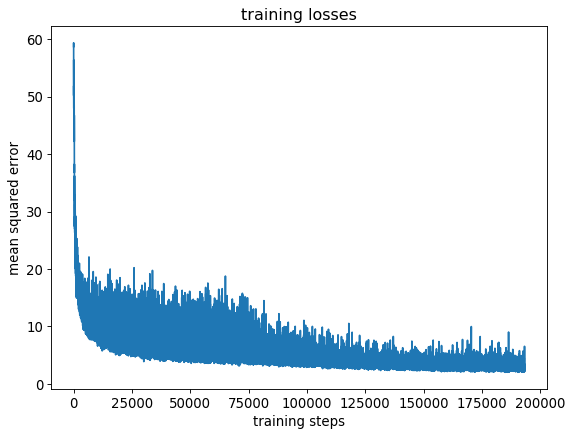

In [28]:
plt.plot(trn_losses)
# plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
# plt.legend(["trn", "val"])
plt.show()

In [27]:
# x_prd, y_prd = data_generator(nsamples=512, 
#                               dim_x=dim_x, 
#                                 init_steps=init_steps, 
#                                 delta_sim_steps = delta_sim_steps,
#                                 dx = dx, 
#                                 dt = dt,
#                                 gamma=gamma, 
#                                 seed =seed_prd,
#                                 device = device)
# prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

In [29]:
err = []
for ix, item_prd in enumerate(prd_dataset):
    x1 = item_prd['x'][None].to(device)
    y1 = item_prd['y'][None].to(device)
    y2 = model(x1)
    err.append(np.sqrt(mse_loss(y1.detach().cpu(), y2.detach().cpu())))

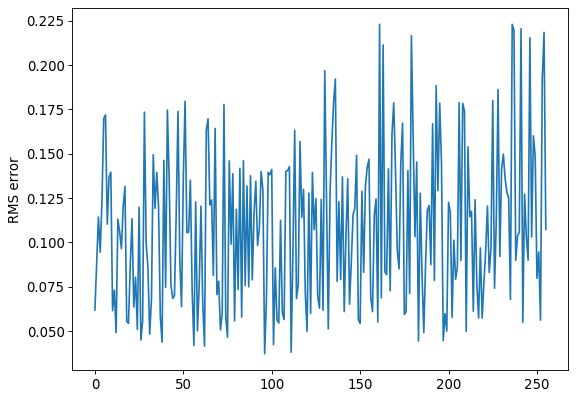

Mean Error on Validation Set: 0.1085


In [30]:
plt.plot(np.arange(len(prd_dataset)), err)
plt.ylabel("RMS error")
plt.show()

print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))

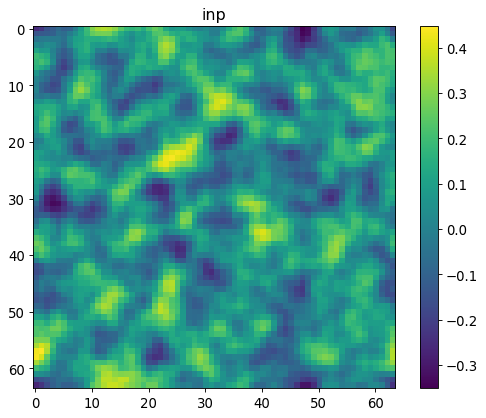

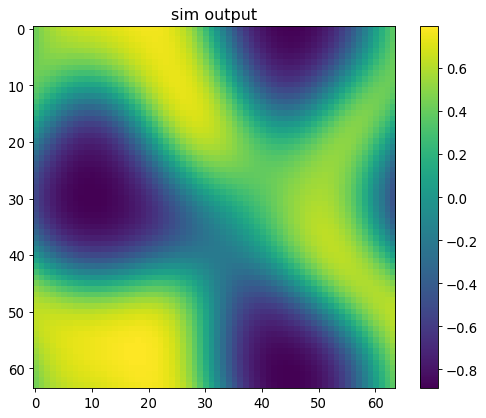

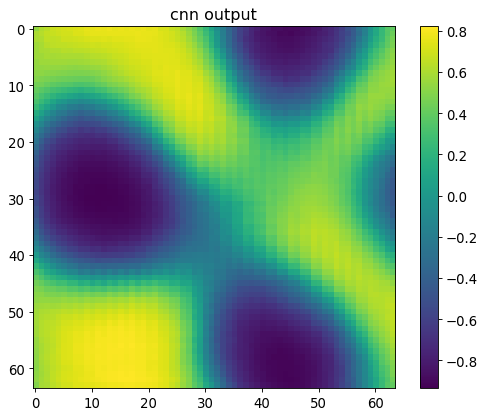

tensor(0.0080, device='cuda:0', dtype=torch.float64)


In [31]:
ix = 24

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
model.eval()
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

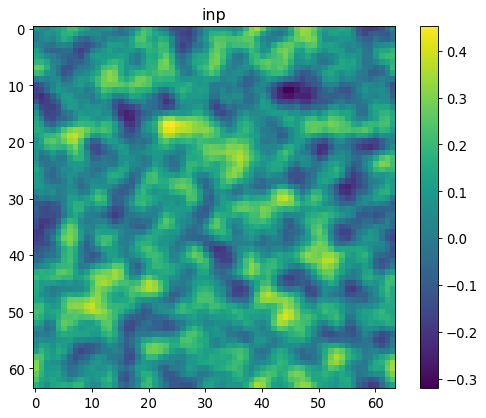

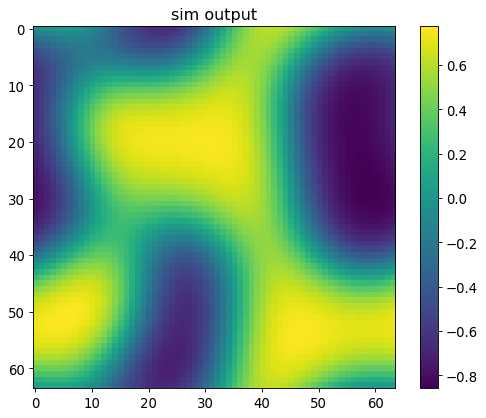

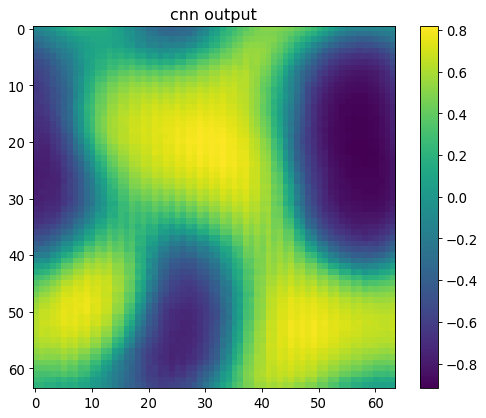

tensor(0.0128, device='cuda:0', dtype=torch.float64)


In [32]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

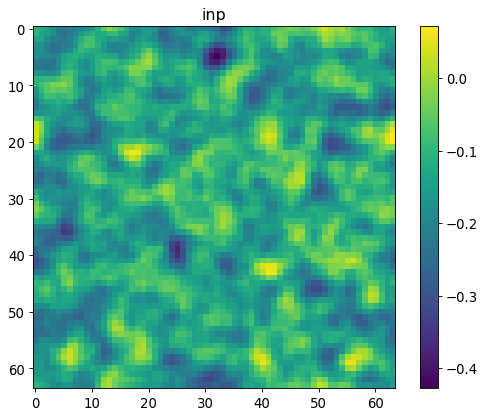

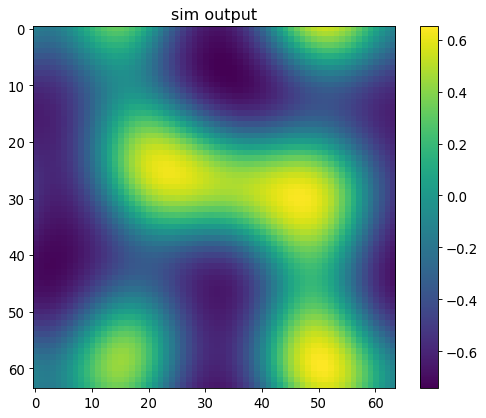

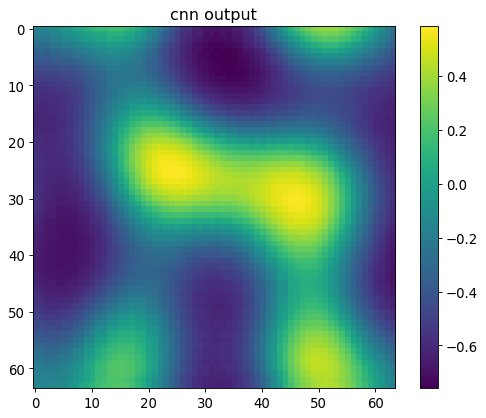

tensor(0.0098, device='cuda:0', dtype=torch.float64)


In [34]:
ix = -3

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

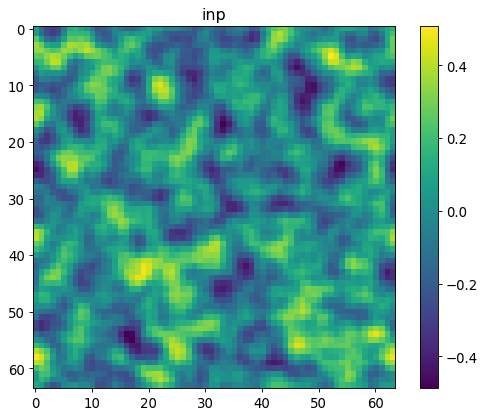

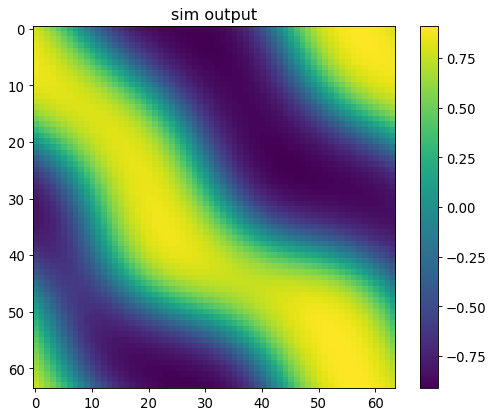

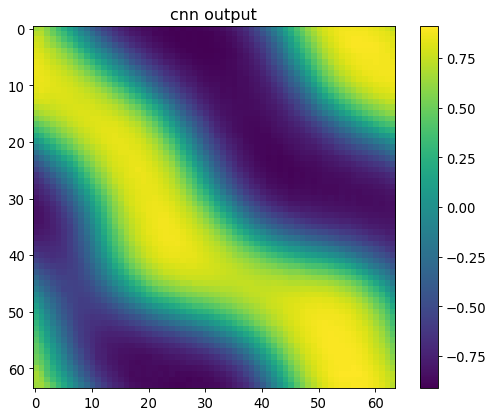

tensor(0.0020, device='cuda:0', dtype=torch.float64)


In [52]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[1], "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)